In [1]:
import os
import torch
import gzip
import struct
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable

from matplotlib import pyplot as plt
%matplotlib inline

# MNIST

In [2]:
device = torch.device("cuda:0")

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.linear1 = nn.Linear(32*7*7, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = nn.ReLU()(x)

        x = self.linear2(x)
        return nn.functional.log_softmax(x, dim=1)

In [4]:
def train(model, criterion, optimizer, dataloader):
    valid_level_accu_before = None
    valid_level_f1_before = None
    
    f1 = []
    accu = []
    losses = []
    for epoch in range(N_EPOCHS):
        model.train()
        tr_loss = 0
        tr_preds = None
        tr_labels = None
        
        for step, batch in enumerate(dataloader):
            data = batch[0].to(device)
            label = batch[1].to(device)
            output = model(data)
            loss = criterion(output, label.squeeze(-1))
            preds = torch.softmax(output, dim=1).data.cpu()
            if(tr_preds is None):
                tr_preds = preds
            else:
                tr_preds = torch.cat((tr_preds, preds), dim=0)
            if(tr_labels is None):
                tr_labels = label.data.cpu()
            else:
                tr_labels = torch.cat((tr_labels, label.data.cpu()), dim=0)   
            loss.backward()
            tr_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.cpu().detach().numpy())
            print("Epoch %d, step %d, loss = %.4f"%(epoch, step, loss))

        
        y_pred = torch.argmax(tr_preds, dim=1).cpu().numpy()
        y_true = tr_labels
        accu.append(accuracy_score(y_true,y_pred))
        f1.append(f1_score(y_true, y_pred, average='macro'))
        print("Epoch %d, accu = %.4f, f1_score = %.4f"%(epoch, accu[epoch], f1[epoch]))
    
    return losses, accu, f1

In [5]:
def test(model, dataloader):
    tr_preds = None
    tr_labels = None
    correct = 0
    total = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.softmax(outputs, dim=1).data.cpu()
        if(tr_preds is None):
            tr_preds = preds
        else:
            tr_preds = torch.cat((tr_preds, preds), dim=0)
        if(tr_labels is None):
            tr_labels = labels.data.cpu()
        else:
            tr_labels = torch.cat((tr_labels, labels.data.cpu()), dim=0)   
    y_pred = torch.argmax(tr_preds, dim=1).cpu().numpy()
    y_true = tr_labels
    accu = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("Test, accu = %.4f, f1_score = %.4f"%(accu, f1))
    return accu, f1

In [27]:
def plot_figures(loss, train_accu, train_f1, test_accu, test_f1, LR, num_epochs):
    plt.figure(figsize=(20,7))
    
    plt.subplot(1,2,1)
    plt.plot(loss, label="Learning_rate = %f, num_epochs = %d"%(LR, num_epochs))
    plt.xlabel("num_iterations")
    plt.ylabel("loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_accu, "-", color = "red", label="train_accuracy")
    plt.plot(train_f1, "-.", color = "blue", label="train_F1_score")
    plt.xlabel("num_epochs")
    plt.ylabel("value")
    plt.legend()
    plt.title("test accu = %.4f, test f1_score = %.4f"%(test_accu, test_f1))
    plt.show()

# 超参数1

In [6]:
BATCH_SIZE = 128
N_EPOCHS = 20
learning_rate = 0.001

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

In [8]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [9]:
loss1, accu1, f1_score1 = train(cnn, criterion, optimizer, train_loader)

Epoch 0, step 0, loss = 2.3068
Epoch 0, step 1, loss = 2.2789
Epoch 0, step 2, loss = 2.2427
Epoch 0, step 3, loss = 2.2252
Epoch 0, step 4, loss = 2.1583
Epoch 0, step 5, loss = 2.1099
Epoch 0, step 6, loss = 2.0190
Epoch 0, step 7, loss = 1.9413
Epoch 0, step 8, loss = 1.8066
Epoch 0, step 9, loss = 1.7961
Epoch 0, step 10, loss = 1.6611
Epoch 0, step 11, loss = 1.5145
Epoch 0, step 12, loss = 1.3897
Epoch 0, step 13, loss = 1.2956
Epoch 0, step 14, loss = 1.1072
Epoch 0, step 15, loss = 1.2480
Epoch 0, step 16, loss = 0.9460
Epoch 0, step 17, loss = 0.9874
Epoch 0, step 18, loss = 0.8095
Epoch 0, step 19, loss = 0.8371
Epoch 0, step 20, loss = 0.8505
Epoch 0, step 21, loss = 0.5792
Epoch 0, step 22, loss = 0.6449
Epoch 0, step 23, loss = 0.5721
Epoch 0, step 24, loss = 0.5953
Epoch 0, step 25, loss = 0.5646
Epoch 0, step 26, loss = 0.5201
Epoch 0, step 27, loss = 0.4866
Epoch 0, step 28, loss = 0.5103
Epoch 0, step 29, loss = 0.3857
Epoch 0, step 30, loss = 0.6419
Epoch 0, step 31, 

In [10]:
test_accu1, test_f11 = test(cnn, test_loader)

Test, accu = 0.9922, f1_score = 0.9921


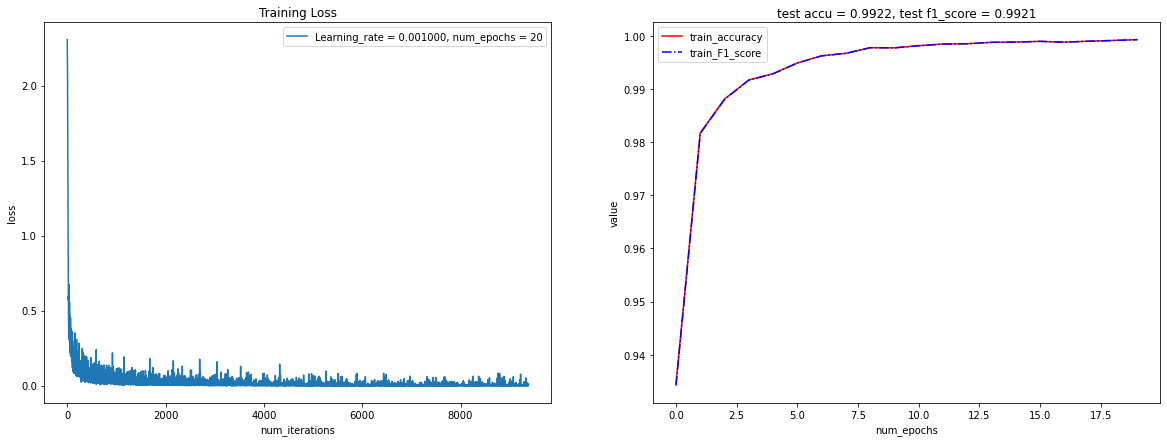

In [28]:
plot_figures(loss1, accu1, f1_score1, test_accu1, test_f11, learning_rate, N_EPOCHS)

# 超参数2

In [29]:
BATCH_SIZE = 128
N_EPOCHS = 20
learning_rate = 1

In [30]:
train_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

In [31]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [32]:
loss2, accu2, f1_score2 = train(cnn, criterion, optimizer, train_loader)

Epoch 0, step 0, loss = 2.3025
Epoch 0, step 1, loss = 2955683.5000
Epoch 0, step 2, loss = 25060.0801
Epoch 0, step 3, loss = 47.7033
Epoch 0, step 4, loss = 57.7385
Epoch 0, step 5, loss = 44.9065
Epoch 0, step 6, loss = 2013.0638
Epoch 0, step 7, loss = 35.8649
Epoch 0, step 8, loss = 24.8122
Epoch 0, step 9, loss = 16.9250
Epoch 0, step 10, loss = 18.5274
Epoch 0, step 11, loss = 14.0999
Epoch 0, step 12, loss = 8.0664
Epoch 0, step 13, loss = 7.4909
Epoch 0, step 14, loss = 5.7913
Epoch 0, step 15, loss = 4.2963
Epoch 0, step 16, loss = 3.6640
Epoch 0, step 17, loss = 3.6818
Epoch 0, step 18, loss = 3.6307
Epoch 0, step 19, loss = 3.1821
Epoch 0, step 20, loss = 2.6357
Epoch 0, step 21, loss = 2.7870
Epoch 0, step 22, loss = 2.8367
Epoch 0, step 23, loss = 2.6330
Epoch 0, step 24, loss = 2.5945
Epoch 0, step 25, loss = 2.6156
Epoch 0, step 26, loss = 2.6009
Epoch 0, step 27, loss = 2.5681
Epoch 0, step 28, loss = 2.5020
Epoch 0, step 29, loss = 2.6037
Epoch 0, step 30, loss = 2.72

In [33]:
test_accu2, test_f12 = test(cnn, test_loader)

Test, accu = 0.1028, f1_score = 0.0186


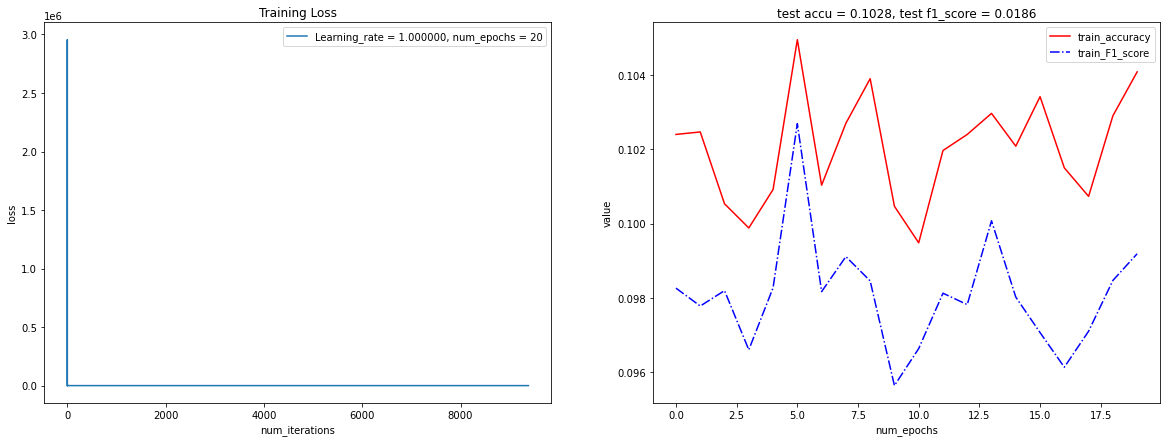

In [34]:
plot_figures(loss2, accu2, f1_score2, test_accu2, test_f12, learning_rate, N_EPOCHS)

# 超参数3

In [47]:
BATCH_SIZE = 65536
N_EPOCHS = 20
learning_rate = 0.001

In [48]:
train_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset', train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

In [49]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [50]:
loss3, accu3, f1_score3 = train(cnn, criterion, optimizer, train_loader)

Epoch 0, step 0, loss = 2.3012
Epoch 0, accu = 0.1107, f1_score = 0.0495
Epoch 1, step 0, loss = 2.2578
Epoch 1, accu = 0.4138, f1_score = 0.3279
Epoch 2, step 0, loss = 2.2023
Epoch 2, accu = 0.4958, f1_score = 0.3981
Epoch 3, step 0, loss = 2.1249
Epoch 3, accu = 0.5497, f1_score = 0.4621
Epoch 4, step 0, loss = 2.0291
Epoch 4, accu = 0.6526, f1_score = 0.5962
Epoch 5, step 0, loss = 1.9153
Epoch 5, accu = 0.6671, f1_score = 0.6218
Epoch 6, step 0, loss = 1.7827
Epoch 6, accu = 0.6928, f1_score = 0.6653
Epoch 7, step 0, loss = 1.6339
Epoch 7, accu = 0.7246, f1_score = 0.7065
Epoch 8, step 0, loss = 1.4745
Epoch 8, accu = 0.7427, f1_score = 0.7275
Epoch 9, step 0, loss = 1.3108
Epoch 9, accu = 0.7550, f1_score = 0.7429
Epoch 10, step 0, loss = 1.1512
Epoch 10, accu = 0.7701, f1_score = 0.7617
Epoch 11, step 0, loss = 1.0035
Epoch 11, accu = 0.7848, f1_score = 0.7791
Epoch 12, step 0, loss = 0.8745
Epoch 12, accu = 0.7942, f1_score = 0.7900
Epoch 13, step 0, loss = 0.7667
Epoch 13, acc

In [51]:
test_accu3, test_f13 = test(cnn, test_loader)

Test, accu = 0.8721, f1_score = 0.8706


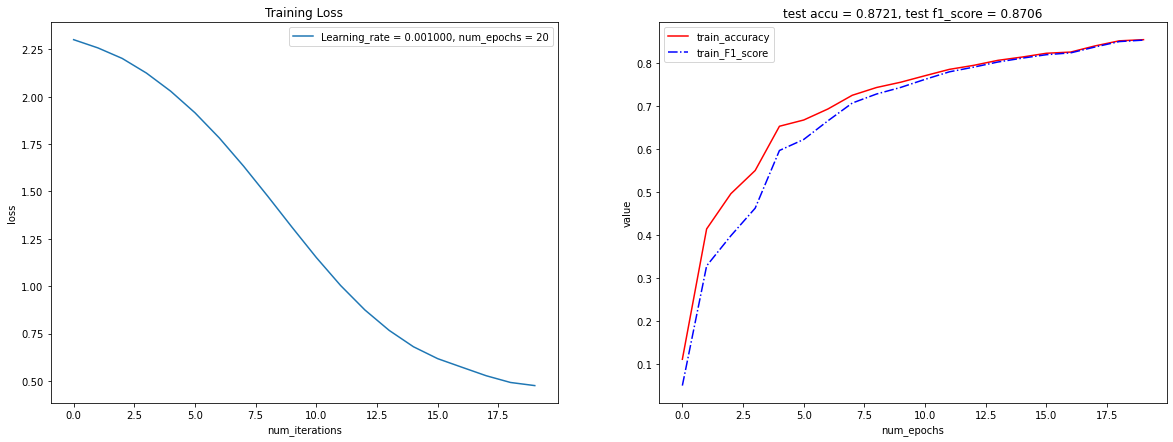

In [52]:
plot_figures(loss3, accu3, f1_score3, test_accu3, test_f13, learning_rate, N_EPOCHS)